# Average Velocity vs Injection Rate Analysis

This notebook studies how average velocity varies with injection rate (α) for different traffic light durations (t_green).

## Import Libraries and Setup

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add parent directory to path to import project modules
sys.path.insert(0, os.path.abspath('..'))

from dispatcher import SimulationDispatcher, generate_parameter_grid

# Set seaborn theme for consistent styling
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams['figure.dpi'] = 100

## Simulation Parameters

We fix the following parameters:
- Road length: 200
- Maximum velocity (vmax): 4
- Random braking probability (p_b): 0.1
- Lane change probability (p_chg): 0.1
- Red light violation probability (p_red): 0.1
- Skid probability (p_skid): 0

We vary:
- Injection rate (α): 20 values from 0.05 to 1.0
- Green light period (t_green): {30, 40, 50, 60, 70, 80}

In [2]:
# Fixed parameters
LENGTH = 100
VMAX = 4
P_B = 0.1
P_CHG = 0.1
P_RED = 0.1
P_SKID = 0.0
STEPS = 100000
REPLICATIONS = 5
RECORD_STEPS = 10000
# Variable parameters
injection_rates = np.linspace(0.05, 1.0, 20)
t_green_values = [30, 50, 70, 90, 110, 130]

print(f"Number of injection rate values: {len(injection_rates)}")
print(f"Injection rates: {injection_rates}")
print(f"t_green values: {t_green_values}")
print(f"Number of replications per configuration: {REPLICATIONS}")
print(f"Total simulations: {len(injection_rates) * len(t_green_values) * REPLICATIONS}")

Number of injection rate values: 20
Injection rates: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
t_green values: [30, 50, 70, 90, 110, 130]
Number of replications per configuration: 5
Total simulations: 600


## Generate Simulation Configurations

In [3]:
# Generate all parameter combinations
configs = generate_parameter_grid(
    length_values=[LENGTH],
    vmax_values=[VMAX],
    t_green_values=t_green_values,
    injection_rate_values=injection_rates.tolist(),
    p_b_values=[P_B],
    p_chg_values=[P_CHG],
    p_red_values=[P_RED],
    p_skid_values=[P_SKID],
    steps=STEPS,
    metrics_start_step=STEPS - RECORD_STEPS,
    replications=REPLICATIONS
)

print(f"Generated {len(configs)} simulation configurations")
print(f"\nFirst configuration:")
print(configs[0])

output_file = "avg_speed_test.csv"

Generated 600 simulation configurations

First configuration:
SimulationConfig(length=100, vmax=4, t_green=30, injection_rate=0.05, p_b=0.1, p_chg=0.1, p_red=0.1, p_skid=0.0, steps=100000, metrics_start_step=90000, config_id=0)


## Run Simulations

This will take some time. The dispatcher will run all simulations in parallel and save results to a CSV file.

In [ ]:
# Create dispatcher and run simulations

dispatcher = SimulationDispatcher(
    output_file=output_file,
    use_multiprocessing=True,
    max_workers=None,  # Use all available CPU cores
    verbose=True
)

# Run all simulations
results = dispatcher.run(configs)

print(f"\nSimulations complete! Results saved to {output_file}")

## Load and Process Results

In [4]:
# Load results from CSV
df = pd.read_csv(output_file)

# Display basic info
print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total rows: 600

Columns: ['timestamp', 'config_id', 'length', 'vmax', 't_green', 'injection_rate', 'p_b', 'p_chg', 'p_red', 'p_skid', 'steps', 'metrics_start_step', 'n_lateral', 'n_rear_end', 'n_vehicles', 'throughput', 'lateral_to_rear_end_ratio', 'time', 'total_time', 'completed_vehicles', 'avg_travel_time', 'avg_speed']

First few rows:


,timestamp,config_id,length,vmax,t_green,injection_rate,p_b,p_chg,p_red,p_skid,...,n_lateral,n_rear_end,n_vehicles,throughput,lateral_to_rear_end_ratio,time,total_time,completed_vehicles,avg_travel_time,avg_speed
0,2025-11-10T13:31:48.841064,0,100,4,30,0.05,0.1,0.1,0.1,0.0,...,68,0,2025,2011,0,4.116852,4.116984,2009,31.369338,15.685257
1,2025-11-10T13:31:48.951183,3,100,4,30,0.05,0.1,0.1,0.1,0.0,...,70,0,2010,2005,0,4.226532,4.226709,2003,31.407389,15.795364
2,2025-11-10T13:31:48.967785,2,100,4,30,0.05,0.1,0.1,0.1,0.0,...,75,0,1917,1905,0,4.243207,4.243361,1904,31.798845,16.302620
3,2025-11-10T13:31:48.983835,4,100,4,30,0.05,0.1,0.1,0.1,0.0,...,85,0,1959,1938,0,4.259177,4.259335,1933,31.755303,15.990320
4,2025-11-10T13:31:49.107007,1,100,4,30,0.05,0.1,0.1,0.1,0.0,...,80,0,1976,1964,0,4.382887,4.383044,1961,31.971953,15.740682


## Aggregate Results

Average the velocity across all replications for each combination of injection_rate and t_green.

In [5]:
# Group by injection_rate and t_green, then calculate mean and std
aggregated = df.groupby(['injection_rate', 't_green']).agg({
    'avg_speed': ['mean', 'std', 'count'],
    'throughput': 'mean',
    'avg_travel_time': 'mean',
    'completed_vehicles': 'mean'
}).reset_index()

# Flatten column names
aggregated.columns = ['injection_rate', 't_green', 'avg_speed_mean', 'avg_speed_std', 'n_replications', 
                      'throughput_mean', 'avg_travel_time_mean', 'completed_vehicles_mean']

print(f"Aggregated data shape: {aggregated.shape}")
print(f"\nSample aggregated data:")
aggregated.head(10)

Aggregated data shape: (120, 8)

Sample aggregated data:


,injection_rate,t_green,avg_speed_mean,avg_speed_std,n_replications,throughput_mean,avg_travel_time_mean,completed_vehicles_mean
0,0.05,30,15.902849,0.251329,5,1964.6,31.660565,1962.0
1,0.05,50,15.543908,0.320562,5,1945.2,32.840389,1943.4
2,0.05,70,15.157482,0.510714,5,1971.8,33.212121,1969.4
3,0.05,90,15.283251,0.367476,5,1918.8,33.737964,1913.8
4,0.05,110,14.482907,0.443237,5,2014.0,34.064492,2009.0
5,0.05,130,14.722082,0.257439,5,1973.4,34.325238,1971.4
6,0.10,30,7.679910,0.124871,5,3894.8,32.667747,3887.2
7,0.10,50,7.489287,0.057883,5,3831.0,34.200847,3828.6
8,0.10,70,7.149628,0.053415,5,3813.8,36.108052,3810.8
9,0.10,90,6.832465,0.137132,5,3873.2,37.412310,3864.8


## Create Plot: Average Velocity vs α for Different t_green Values

This plot shows how average velocity varies with injection rate for different traffic light durations.

Plot saved as 'avg_speed_plot.png'


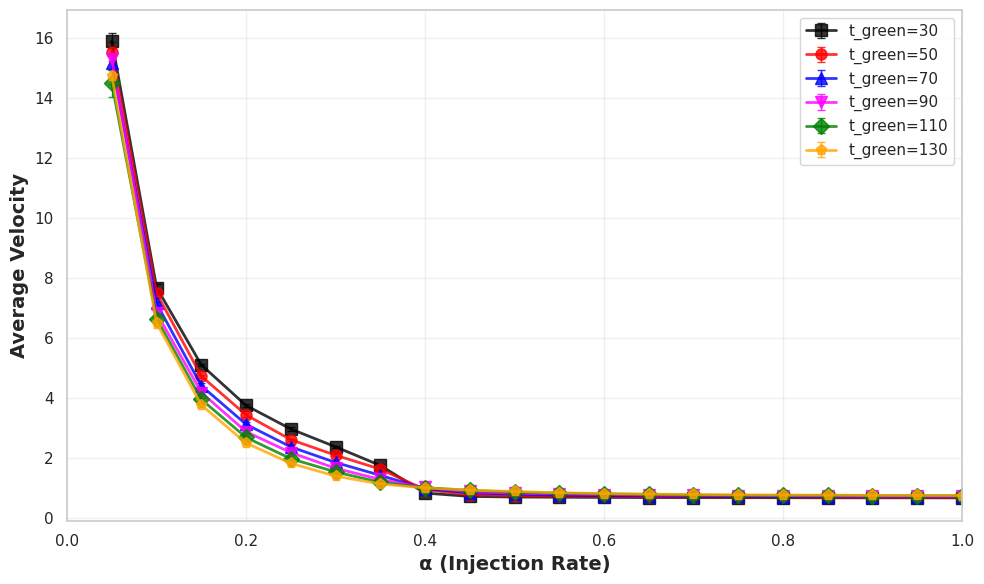

In [6]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define markers and colors for each t_green value
markers = ['s', 'o', '^', 'v', 'D', 'p']
colors = ['black', 'red', 'blue', 'magenta', 'green', 'orange']

# Plot each t_green value as a separate line with error bars
for i, t_green in enumerate(t_green_values):
    data = aggregated[aggregated['t_green'] == t_green]
    
    plt.errorbar(
        data['injection_rate'], 
        data['avg_speed_mean'],
        yerr=data['avg_speed_std'],
        marker=markers[i],
        color=colors[i],
        linestyle='-',
        linewidth=2,
        markersize=8,
        label=f't_green={t_green}',
        markerfacecolor=colors[i],
        markeredgecolor=colors[i],
        capsize=3,
        capthick=1,
        elinewidth=1,
        alpha=0.8
    )

# Formatting
plt.xlabel('α (Injection Rate)', fontsize=14, fontweight='bold')
plt.ylabel('Average Velocity', fontsize=14, fontweight='bold')
plt.xlim(0, 1.0)
plt.legend(loc='best', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig('avg_speed_plot.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'avg_speed_plot.png'")

plt.show()

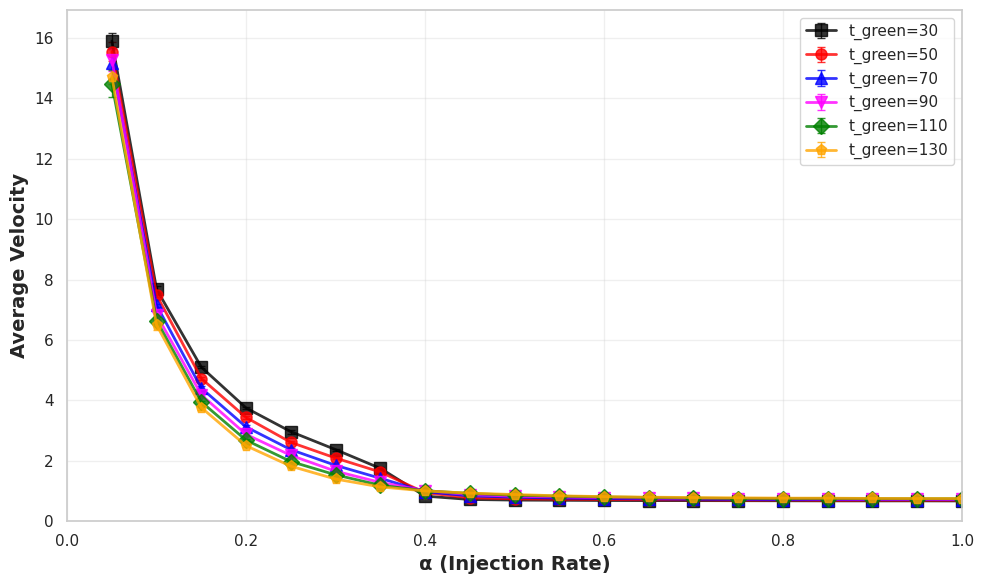

In [7]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define markers and colors for each t_green value
markers = ['s', 'o', '^', 'v', 'D', 'p']
colors = ['black', 'red', 'blue', 'magenta', 'green', 'orange']

# Plot each t_green value as a separate line with error bars
for i, t_green in enumerate(t_green_values):
    data = aggregated[aggregated['t_green'] == t_green]
    
    plt.errorbar(
        data['injection_rate'], 
        data['avg_speed_mean'],
        yerr=data['avg_speed_std'],
        marker=markers[i],
        color=colors[i],
        linestyle='-',
        linewidth=2,
        markersize=8,
        label=f't_green={t_green}',
        markerfacecolor=colors[i],
        markeredgecolor=colors[i],
        capsize=3,
        capthick=1,
        elinewidth=1,
        alpha=0.8
    )

# Formatting
plt.xlabel('α (Injection Rate)', fontsize=14, fontweight='bold')
plt.ylabel('Average Velocity', fontsize=14, fontweight='bold')
plt.xlim(0, 1.0)
plt.ylim(bottom=0)
plt.legend(loc='best', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig('avg_speed_plot_bottom_0.png', dpi=300, bbox_inches='tight')

plt.show()

## Summary Statistics

Display some key statistics about the results.

In [21]:
# Find maximum and minimum average velocity for each t_green
print("Average velocity statistics for each t_green value:\n")
for t_green in t_green_values:
    data = aggregated[aggregated['t_green'] == t_green]
    max_idx = data['avg_speed_mean'].idxmax()
    min_idx = data['avg_speed_mean'].idxmin()
    max_row = data.loc[max_idx]
    min_row = data.loc[min_idx]
    
    print(f"t_green = {t_green}:")
    print(f"  Maximum avg_speed = {max_row['avg_speed_mean']:.4f} at α = {max_row['injection_rate']:.3f}")
    print(f"  Minimum avg_speed = {min_row['avg_speed_mean']:.4f} at α = {min_row['injection_rate']:.3f}")
    print(f"  Throughput at max speed = {max_row['throughput_mean']:.1f}")
    print(f"  Throughput at min speed = {min_row['throughput_mean']:.1f}")
    print()

# Overall statistics
print("\nOverall statistics:")
print(f"Total simulations run: {len(df)}")
print(f"Total unique configurations: {len(aggregated)}")
print(f"Replications per configuration: {REPLICATIONS}")
print(f"Injection rate range: [{injection_rates.min():.2f}, {injection_rates.max():.2f}]")
print(f"t_green values tested: {t_green_values}")
print(f"Overall avg_speed range: [{aggregated['avg_speed_mean'].min():.4f}, {aggregated['avg_speed_mean'].max():.4f}]")

Average velocity statistics for each t_green value:

t_green = 30:
  Maximum avg_speed = 3.5524 at α = 0.100
  Minimum avg_speed = 3.2895 at α = 1.000
  Throughput at max speed = 1015.0
  Throughput at min speed = 9222.4

t_green = 50:
  Maximum avg_speed = 3.5332 at α = 0.050
  Minimum avg_speed = 3.0611 at α = 1.000
  Throughput at max speed = 502.0
  Throughput at min speed = 9230.8

t_green = 70:
  Maximum avg_speed = 3.4890 at α = 0.100
  Minimum avg_speed = 2.8849 at α = 1.000
  Throughput at max speed = 1004.8
  Throughput at min speed = 9212.0

t_green = 90:
  Maximum avg_speed = 3.4895 at α = 0.050
  Minimum avg_speed = 2.7179 at α = 1.000
  Throughput at max speed = 498.8
  Throughput at min speed = 9219.2

t_green = 110:
  Maximum avg_speed = 3.4725 at α = 0.050
  Minimum avg_speed = 2.5605 at α = 1.000
  Throughput at max speed = 507.8
  Throughput at min speed = 9206.4

t_green = 130:
  Maximum avg_speed = 3.4625 at α = 0.050
  Minimum avg_speed = 2.4393 at α = 1.000
  Thr

## Interpretation

The plot shows how the average velocity varies with the injection rate (α) for different traffic light durations (t_green):

1. **General Trend**: Average velocity typically decreases as injection rate increases, reflecting traffic congestion effects. At low injection rates, vehicles can move freely, but as more vehicles enter the system, congestion reduces average speeds.

2. **Effect of t_green**: 
   - Shorter green light durations (smaller t_green) may cause more frequent stops, potentially reducing average velocity
   - Longer green light durations allow more vehicles to pass through without stopping, potentially maintaining higher average speeds
   - The optimal t_green balances flow efficiency with waiting times

3. **Saturation Regime**: At very high injection rates (α → 1), the system becomes saturated and average velocity approaches a minimum value as traffic becomes heavily congested.

4. **Critical Injection Rate**: Each t_green value may have a critical injection rate where the transition from free-flow to congested traffic occurs, marked by a steep decrease in average velocity.

5. **Traffic Light Synchronization**: The interaction between injection rate and traffic light timing affects how efficiently vehicles can traverse the intersection, impacting overall system velocity.